#### Please Scroll all the way to bottom until you see Q1 and Q2 titles

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib; matplotlib.use('TkAgg')
import torch
import os
import kornia as K
import sys
import math
import random
import scipy
%matplotlib inline

In [2]:

def imageRead(fileName):
    img = cv2.imread(fileName)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = (img.astype(np.float32) / 255.0)
    return img

def grayAndNormalize(img):
    # Convert the image to grayscale
    if img.dtype == np.uint8:
        # Convert the image to grayscale directly
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        # If the image is float32, convert it to 8-bit first
        img = (img * 255).astype('uint8')
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Normalize the image to 8-bit 
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    return img

def plot2Imgs(img1,img2):
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.title("Lt Image")
    plt.imshow(img1)
    plt.subplot(1,2,2)
    plt.title("Rt Image")
    plt.imshow(img2)

def img2tensor(img):
    img = torch.from_numpy(img)
    img = img.permute(2,0,1)
    img = img.unsqueeze(0)
    img = img.float()
    # No grayscaling this time    
    img = img
    return img

# This is different too because of rgb channels
def tensor2img(tensor):
    img = tensor.squeeze(0)
    img = img.permute(1,2,0)    
    img = img.detach().numpy()    
    return img

In [3]:
def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    # Pad smaller image if one is smaller than the other
    if img1.shape[0] < img2.shape[0]:
        img1 = np.pad(img1, ((0, img2.shape[0] - img1.shape[0]), (0, 0)), 'constant')
    elif img2.shape[0] < img1.shape[0]:
        img2 = np.pad(img2, ((0, img1.shape[0] - img2.shape[0]), (0, 0)), 'constant')

        
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')



In [4]:
def getTransform(pointsL, pointsR, minPoints, threshold, iterations):
    """
    RANSAC algorithm for finding the best homography
    :param points: list of matching points
    :param minPoints: minimum number of points needed for the model
    :param threshold: threshold for inlier selection
    :param iterations: number of iterations
    :return: Best Inliers to calc another affine on (to use overfitted data)
    """    
    pointsL = np.array(pointsL)
    pointsR = np.array(pointsR)
    # Make the points homogeneous
    pointsL = np.hstack((pointsL, np.ones((pointsL.shape[0],1))))
    pointsR = np.hstack((pointsR, np.ones((pointsR.shape[0],1))))
    # Initialize the best inliers
    inliersL = []
    inliersR = []
    # Initialize the best score
    maxScore = 0
    for iter in range(iterations):        
        score = 0   
        tempInliersL = []
        tempInliersR = []
        # Randomly select minPoints points from the list of points
        randomIndices = random.sample(list(np.arange(pointsL.shape[0])),minPoints)
        minSetL = np.array(pointsL[randomIndices][0:])
        minSetR = np.array(pointsR[randomIndices][0:])

        # Add minset to tempInliers
        for i in range(minPoints):
            tempInliersL.append(pointsL[randomIndices[i]])
            tempInliersR.append(pointsR[randomIndices[i]])
        # Then we calculate the transform matrix
        try:
            if minPoints == 3:
                # If we have 3 points, we can use the direct method (in try because we might have singular matrix forming from chosen points)
                transform = np.linalg.inv(minSetL) @ minSetR
            elif minPoints == 4:
                # If we have 4 points, we can use the SVD method
                transform = homographyFinder(minSetL, minSetR)                 
        except:            
            # If we have a singular matrix, we skip this iteration
            continue

        # Then we calculate the score for this transform by applying it to all the points and checking if they are within the threshold
        for i in range(pointsL.shape[0]):            
            # Calculate the expected point
            if minPoints == 3:
                # I setup the points as a 3x1 matrix so that I can use the transform matrix directly
                expectedR = pointsL[i] @ transform 
            if minPoints == 4:
                # Here I need to reshape the points to a 3x1 matrix so that I can use the transform matrix directly
                expectedR = transform @ pointsL[i].reshape(-1,1)
                # Since this is a homography, I need to divide by the last element to get the actual point
                expectedR = expectedR / expectedR[2]
                # I reshape it back to a 1x3 matrix so that I can use it in the norm calculation
                expectedR = expectedR.reshape(1,-1)
            # Calculate the difference between the expected point and the actual point
            difference = np.linalg.norm(expectedR - pointsR[i])            
            # If the difference is smaller than the threshold, we add it to the score
            if difference < threshold:                
                # And we add the points to their corresponding inliers
                tempInliersL.append(pointsL[i])
                tempInliersR.append(pointsR[i])
                score += 1
        # If the score is better than the previous best score, we update the best score and best inliers
        if score > maxScore:        
            maxScore = score
            inliersL = tempInliersL
            inliersR = tempInliersR
    # Now that we have tried all the iterations, we can calculate the transform matrix using the best inliers
    inliersL = np.array(inliersL)
    inliersR = np.array(inliersR)
    # In case we don't have a lot of inliers, I wanna warn the user
    if inliersL.shape[0] < minPoints*2:
        print("InliersCount: ", inliersL.shape[0])

    if minPoints == 3:
        # If we have 3 points, we can use the least squares method with pseudo inverse and everything
        return np.delete(((np.linalg.inv(inliersL.T @ inliersL) @ inliersL.T @ inliersR).T), minPoints-1, 0)
    elif minPoints == 4:
        # If we have 4 points, we can use the SVD method again, just overfitted
        return homographyFinder(inliersL, inliersR)    

def homographyFinder(pointsL, pointsR):       
    # Here I turn the points into a matrix A which is 2n x 9 so that I can use SVD on it. 
    if pointsL.shape[0] < 4 or pointsR.shape[0] < 4:
        print("Not enough points")
        return
    matrixA = np.zeros((pointsL.shape[0]*2,9))
    for i in range(pointsL.shape[0]):
        matrixA[i*2] = np.array([-pointsL[i][0], -pointsL[i][1], -1, 0, 0, 0, pointsL[i][0]*pointsR[i][0], pointsL[i][1]*pointsR[i][0], pointsR[i][0]])
        matrixA[i*2+1] = np.array([0, 0, 0, -pointsL[i][0], -pointsL[i][1], -1, pointsL[i][0]*pointsR[i][1], pointsL[i][1]*pointsR[i][1], pointsR[i][1]])    
    # Then I use SVD to find the last row of V and reshape it to a 3x3 matrix
    U, S, V = np.linalg.svd(matrixA)
    V = V[-1].reshape(3,3)
    return V/V[2,2]


In [5]:
def processStitching(img1,img2,transform,minPoints):
    (minOffsetX, minOffsetY), (newWidth, newHeight) = getTransformOffset(transform, img1)
    transform[0][2] += minOffsetX
    transform[1][2] += minOffsetY

    # Do affine / homography warp based on minPoints 
    if minPoints == 3:
        fin = cv2.warpAffine(img1, transform, (newWidth, newHeight))               
    elif minPoints == 4:        
        fin = cv2.warpPerspective(img1, transform, (newWidth, newHeight))                     
    return stitchImages(fin, img2,[minOffsetX, minOffsetY])

def stitchImages(img1, img2, offset,isImg2Right=True):
    # Determine the size of the new image
    newWidth = max(offset[0] + img1.shape[1], img2.shape[1])*2
    newHeight = max(offset[1] + img1.shape[0], img2.shape[0])*2

    # Create the new image canvas
    newImg = np.zeros((newHeight, newWidth, 3))

    # Place img1 on the canvas    

    if isImg2Right:
        newImg[offset[1]:offset[1]+img2.shape[0], offset[0]:offset[0]+img2.shape[1]] = img2
    else:   # THis is a -will probably work- solution.
        # Adjust this part based on your specific requirement if img2 is to the left or otherwise
        newImg[offset[1]:offset[1]+img2.shape[0], :img2.shape[1]] = img2

    # This is where I only place img1 if it is not zero
    mask = np.any(img1 != [0, 0, 0], axis=2)
    mask = erode_mask(mask,3)

    # I use a mask instead of doing the max because I want to avoid black edges and max causes weird blending artifacts.

    newImg_y_end = min(newImg.shape[0], img1.shape[0])
    newImg_x_end = min(newImg.shape[1], img1.shape[1])
    
    newImg[:newImg_y_end, :newImg_x_end][mask] = img1[:newImg_y_end, :newImg_x_end][mask]


    return trimImage(newImg)
    # return newImg


def trimImage(img):
    # Trim the image to the smallest possible size. It finds the first and last row and column that has a non-zero value then trims the image to that size.
    firstRow = 0
    lastRow = img.shape[0]
    firstCol = 0
    lastCol = img.shape[1]
    for row in range(img.shape[0]):
        if np.sum(img[row,:,:]) != 0:
            firstRow = row
            break
    for row in range(img.shape[0]-1,0,-1):
        if np.sum(img[row,:,:]) != 0:
            lastRow = row
            break
    for col in range(img.shape[1]):
        if np.sum(img[:,col,:]) != 0:
            firstCol = col
            break
    for col in range(img.shape[1]-1,0,-1):
        if np.sum(img[:,col,:]) != 0:
            lastCol = col
            break    
    return img[firstRow:lastRow,firstCol:lastCol,:]


def getTransformOffset(transform, img):
    # Get the corners of the image and transform them to find the new corners, then find the offset and size of the new image
    corners = np.array([[0, 0, 1], [0, img.shape[0], 1], [img.shape[1], 0, 1], [img.shape[1], img.shape[0], 1]])
    transformed_corners = transform @ corners.T
    if transformed_corners.shape[0] == 3:
        transformed_corners = transformed_corners / transformed_corners[2]

    min_x = min(0, transformed_corners[0].min())
    min_y = min(0, transformed_corners[1].min())

    max_x = max(img.shape[1], transformed_corners[0].max())
    max_y = max(img.shape[0], transformed_corners[1].max())

    offset_x = int(abs(min_x)) if min_x < 0 else 0
    offset_y = int(abs(min_y)) if min_y < 0 else 0

    new_width = int((max_x - min_x)*1.3)
    new_height = int((max_y - min_y)*1.3)

    return (offset_x, offset_y), (new_width, new_height)


def erode_mask(mask, x):
    
    # Erodes the given binary mask inwards by x pixels. I am using this to avoid black aliased edges when stitching images (that come from warping instead of max).
    structure = scipy.ndimage.generate_binary_structure(2, 2)
    structure = np.kron(structure, np.ones((x,x), dtype=structure.dtype))

    # Perform erosion
    eroded_mask = scipy.ndimage.binary_erosion(mask, structure)

    return eroded_mask

In [6]:
def combineImages(img1,img2,minPoints,threshold,iterations,matchCount):
    gray1 = grayAndNormalize(img1)
    gray2 = grayAndNormalize(img2)

    kp1, ds1 = cv2.SIFT_create().detectAndCompute(gray1,None)
    kp2, ds2 = cv2.SIFT_create().detectAndCompute(gray2,None)

    
    ds3 = scipy.spatial.distance.cdist(ds1, ds2, 'sqeuclidean')


    # First get top 100 matches. We do that by flattening the distance matrix and sorting it, then taking the top 100. 
    # Problem here is that we lose the indices of the matches. 
    # Remember, first index corresponds to a descriptor at some point in the left image, second to the right.
    argsorted = np.argsort(ds3, axis=None)[:matchCount]
    # So we convert the flattened index back to a 2D index
    # Then argsorted[0] is the index of the descriptor in the left image, and argsorted[1] is the index of the descriptor in the right image (sorted by distance)
    argsorted = np.unravel_index(argsorted, ds3.shape)

    # Then, we use the indices above to get the actual points that are top 100 in each image
    # Here, we are creating a sublist from keypoints list, using the elements at indices in argsorted
    inliers1 = [kp1[index].pt for index in argsorted[0]]
    inliers2 = [kp2[index].pt for index in argsorted[1]]
    
    # First make inliers 1 and 2 same size by padding and then hstack them. These are commented as they are not used in the final version.
    # inliers = np.hstack((inliers1, inliers2))
    # plot_inlier_matches(plt.gca(), gray1, gray2, inliers)

    bestTransform = getTransform(inliers1, inliers2, minPoints, threshold, iterations)        

    return processStitching(img1, img2, bestTransform, minPoints)

# Question 1

Affine Transformation will need 3 minimum points for RANSAC to work. The reason is that affine transformation has 6 degrees of freedom and hence 6 unknowns. So, we need 6 equations to solve for these 6 unknowns. Each point will give us 2 equations (x and y coordinates) and hence we need 3 points to solve for the 6 unknowns.

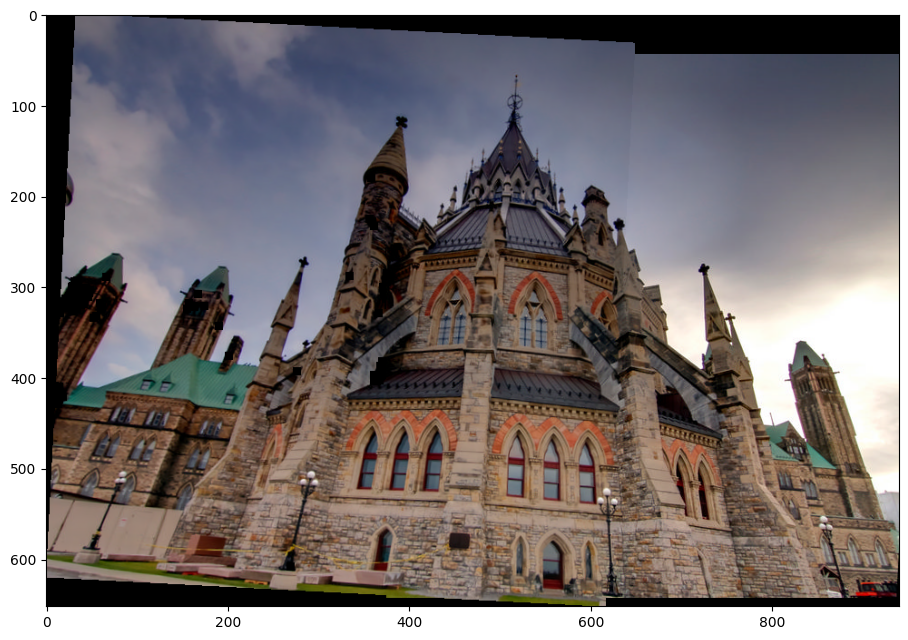

In [12]:
imageSize = "smol" # "smol" or "og"
images = ["Media/q1/" + imageSize + "/parliament-left.jpg","Media/q1/" + imageSize + "/parliament-right.jpg"]
images2 = ["2+1.png","3+2.png"]
img1 = imageRead(images[0])
img2 = imageRead(images[1])
fin = combineImages(img1,img2,3,6,2000,100)
plt.figure(figsize=(11,11))
plt.imshow(fin)

# Question 2
Homography will need 4 minimum points for RANSAC to work. The reason is that homography has 8 degrees of freedom and hence 8 unknowns. So, we need 8 equations to solve for these 8 unknowns. Each point will give us 2 equations (x and y coordinates) and hence we need 4 points to solve for the 8 unknowns.

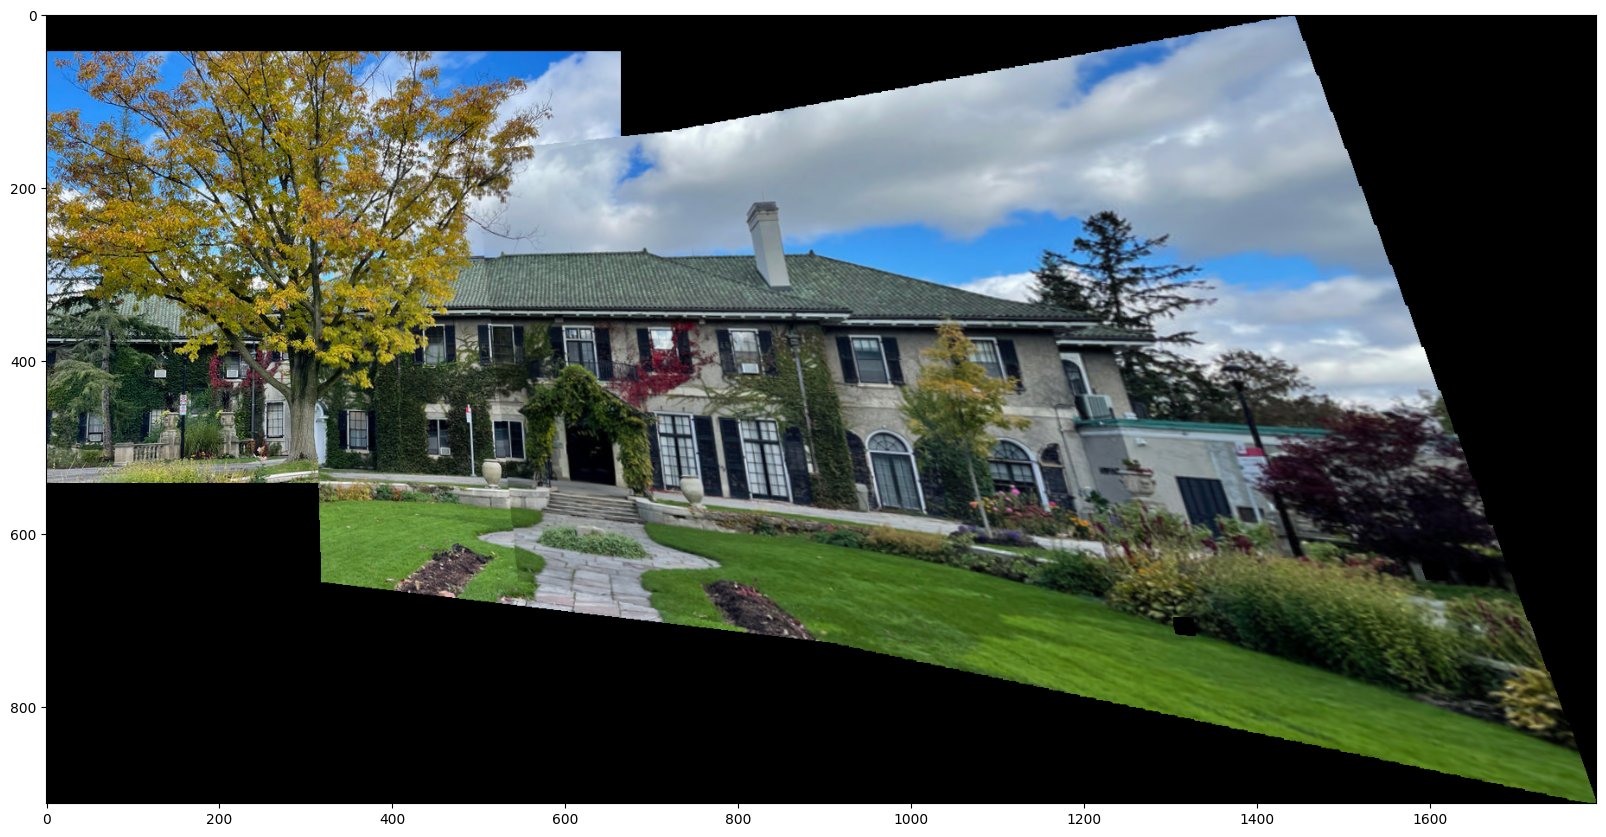

In [8]:
imageSize = "smol" # "smol" or "og"
imageSet = "q2" # "q2" or "q2_3"
images = ["Media/"+imageSet+"/" + imageSize +"/lt.jpg", "Media/"+imageSet+"/" + imageSize +"/mid.jpg","Media/"+imageSet+"/" + imageSize +"/rt.jpg"]
img1 = imageRead(images[0])
img2 = imageRead(images[1])
img3 = imageRead(images[2])
plt.figure(figsize=(20,20))
fin = combineImages(img3,img2,4,0.1,2000,100)
fin = combineImages(fin,img1,4,0.1,2000,200)
# plt.imsave("Results/q2.png", fin)
plt.imshow(fin)

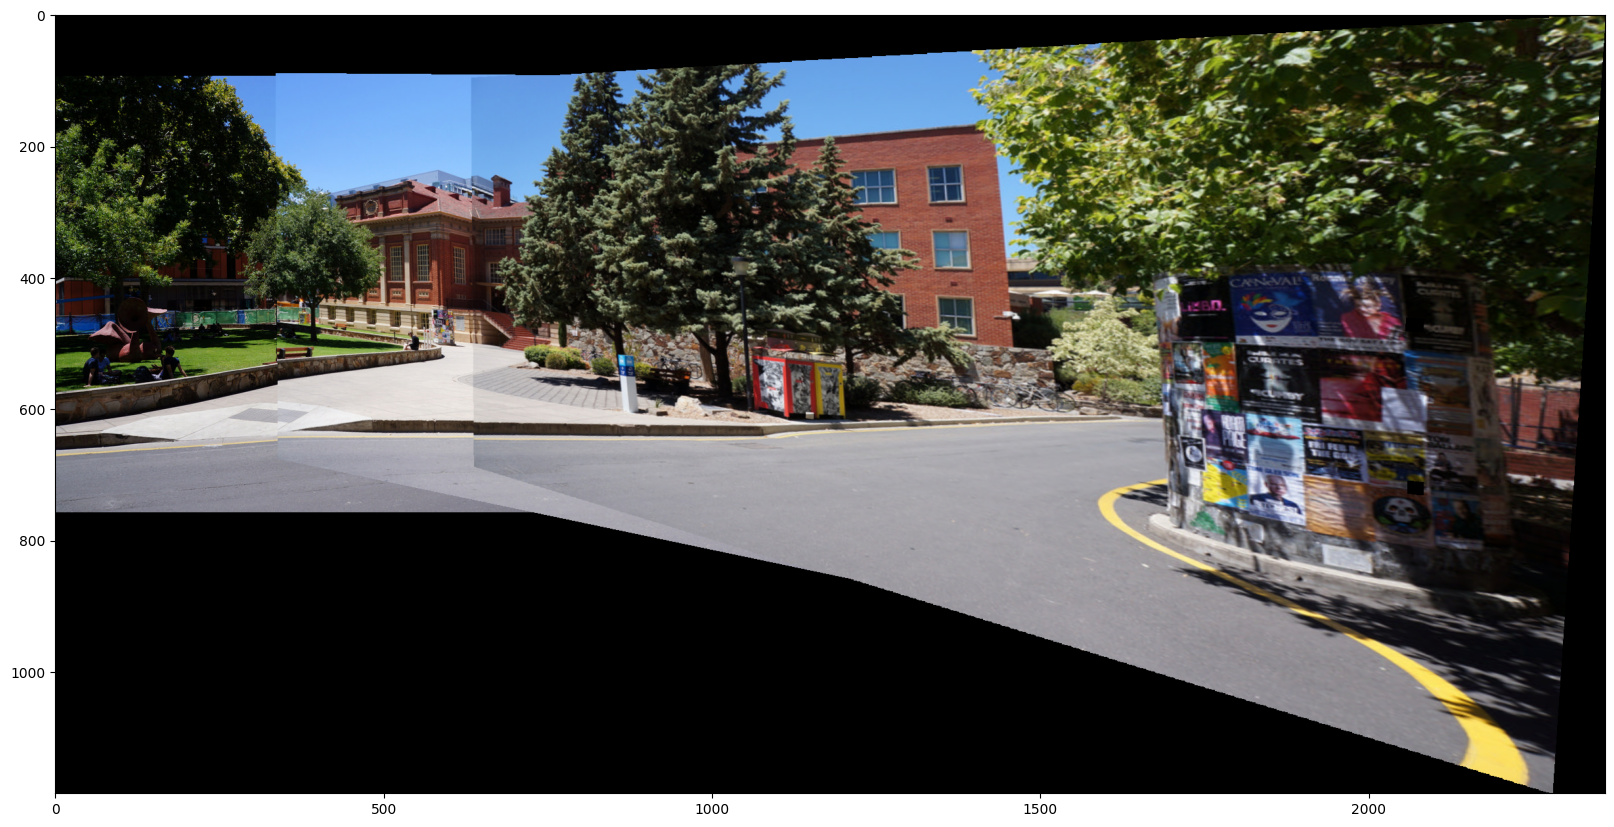

In [16]:
imageSize = "smol" # "smol" or "og"
imageSet = "q2_3" # "q2" or "q2_3"
images = ["Media/"+imageSet+"/" + imageSize +"/lt.jpg", "Media/"+imageSet+"/" + imageSize +"/mid.jpg","Media/"+imageSet+"/" + imageSize +"/rt.jpg"]
img1 = imageRead(images[0])
img2 = imageRead(images[1])
img3 = imageRead(images[2])
plt.figure(figsize=(20,20))
fin = combineImages(img3,img2,4,0.1,6000,100)
fin = combineImages(fin,img1,4,1,10000,140)
# plt.imsave("Results/q2_3.png", fin)
plt.imshow(fin)